<a href="https://colab.research.google.com/github/o54ma-4l5h4r1f/ChessObjectsDetection/blob/Yolov4/yolov4_webcam-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


In this notebook, we implement [YOLOv4](https://blog.roboflow.com/training-yolov4-on-a-custom-dataset/) which is an object detection algorithm for our training.
<br><br>
Darknet is an open source artificial neural network framework written in C and CUDA
<br><br>
[What is Weight (Artificial Neural Network)?](https://deepai.org/machine-learning-glossary-and-terms/weight-artificial-neural-network)


# Let's Start Training 

## Configuring cuDNN on Colab for YOLOv4


In [ ]:
# CUDA: Let's check that Nvidia CUDA drivers are already pre-installed and which version is it.
!/usr/local/cuda/bin/nvcc --version

# Colab added cuDNN as an inherent install - so you don't have to do a thing - major win
!nvidia-smi

# This code ensures you have the correct architecture for your respective GPU
# If you command is not found, look through these GPUs, find the respective
# GPU and add them to the archTypes dictionary

import os
os.environ['GPU_TYPE'] = str(os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read())

def getGPUArch(argument):
  try:
    argument = argument.strip()
    # All Colab GPUs
    archTypes = {
        "Tesla V100-SXM2-16GB": "-gencode arch=compute_70,code=[sm_70,compute_70]",
        "Tesla K80": "-gencode arch=compute_37,code=sm_37",
        "Tesla T4": "-gencode arch=compute_75,code=[sm_75,compute_75]",
        "Tesla P40": "-gencode arch=compute_61,code=sm_61",
        "Tesla P4": "-gencode arch=compute_61,code=sm_61",
        "Tesla P100-PCIE-16GB": "-gencode arch=compute_60,code=sm_60"

      }
    return archTypes[argument]
  except KeyError:
    return "GPU must be added to GPU Commands"
os.environ['ARCH_VALUE'] = getGPUArch(os.environ['GPU_TYPE'])

print("GPU Type: " + os.environ['GPU_TYPE'])
print("ARCH Value: " + os.environ['ARCH_VALUE'])

## Installing Darknet for YOLOv4 on Colab

In [ ]:
%cd /content/
%rm -rf darknet
!git clone https://github.com/roboflow-ai/darknet.git
%cd /content/darknet/

#colab occasionally shifts dependencies around, at the time of authorship, This Makefile works for building Darknet on Colab
%rm Makefile
!wget https://raw.githubusercontent.com/o54ma-4l5h4r1f/ChessObjectsDetection/Yolov4/Makefile
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!sed -i "s/ARCH= -gencode arch=compute_37,code=sm_37/ARCH= ${ARCH_VALUE}/g" Makefile

In [ ]:
!make

## Installing Yolov4 ConvNet weights

In [ ]:
#download the newly released yolov4 ConvNet weights
%cd /content/darknet
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

## Set up Custom Dataset for YOLOv4

In [ ]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="darknet", notebook="roboflow-yolov4")

%cd /content/

rf = Roboflow(api_key="zULeeVmmrvMu6rp8LSoQ")
project = rf.workspace("osama-alsharif").project("chessobjectsdetection-ggjgw")
dataset = project.version(1).download("darknet")

##===================================================================================================

#Set up training file directories for custom dataset
%cd /content/darknet/
%cp {dataset.location}/train/_darknet.labels data/obj.names
%mkdir data/obj
#copy image and labels
%cp {dataset.location}/train/*.jpg data/obj/
%cp {dataset.location}/valid/*.jpg data/obj/

%cp {dataset.location}/train/*.txt data/obj/
%cp {dataset.location}/valid/*.txt data/obj/

with open('data/obj.data', 'w') as out:
  out.write('classes = 5\n')
  out.write('train = data/train.txt\n')
  out.write('valid = data/valid.txt\n')
  out.write('names = data/obj.names\n')
  out.write('backup = backup/')

#write train file (just the image list)
import os

with open('data/train.txt', 'w') as out:
  for img in [f for f in os.listdir(dataset.location + '/train') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

#write the valid file (just the image list)
import os

with open('data/valid.txt', 'w') as out:
  for img in [f for f in os.listdir(dataset.location + '/valid') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

## Write Custom Training Config for YOLOv4

In [10]:
#we build config dynamically based on number of classes
#we build iteratively from base config files. This is the same file shape as cfg/yolo-obj.cfg
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len(dataset.location + '/train/_darknet.labels')
print("writing config for a custom YOLOv4 detector detecting number of classes: " + str(num_classes))

#Instructions from the darknet repo
#change line max_batches to (classes*2000 but not less than number of training images, and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
#change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
if os.path.exists('./cfg/custom-yolov4-detector.cfg'): os.remove('./cfg/custom-yolov4-detector.cfg')


with open('./cfg/custom-yolov4-detector.cfg', 'a') as f:
  f.write('[net]' + '\n')
  f.write('batch=64' + '\n')
  #####smaller subdivisions help the GPU run faster. 12 is optimal, but you might need to change to 24,36,64####
  f.write('subdivisions=24' + '\n')
  f.write('width=416' + '\n')
  f.write('height=416' + '\n')
  f.write('channels=3' + '\n')
  f.write('momentum=0.949' + '\n')
  f.write('decay=0.0005' + '\n')
  f.write('angle=0' + '\n')
  f.write('saturation = 1.5' + '\n')
  f.write('exposure = 1.5' + '\n')
  f.write('hue = .1' + '\n')
  f.write('\n')
  f.write('learning_rate=0.001' + '\n')
  f.write('burn_in=1000' + '\n')
  ######you can adjust up and down to change training time#####
  ##Darknet does iterations with batches, not epochs####
  # max_batches = num_classes*2000
  max_batches = 500
  f.write('max_batches=' + str(max_batches) + '\n')
  f.write('policy=steps' + '\n')
  steps1 = .8 * max_batches
  steps2 = .9 * max_batches
  f.write('steps='+str(steps1)+','+str(steps2) + '\n')

#Instructions from the darknet repo
#change line classes=80 to your number of objects in each of 3 [yolo]-layers:
#change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers.

  with open('cfg/yolov4-custom2.cfg', 'r') as f2:
    content = f2.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 0,1,2' + '\n')
    f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
    f.write('classes=' + str(num_classes) + '\n')

  with open('cfg/yolov4-custom3.cfg', 'r') as f3:
    content = f3.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 3,4,5' + '\n')
    f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
    f.write('classes=' + str(num_classes) + '\n')

  with open('cfg/yolov4-custom4.cfg', 'r') as f4:
    content = f4.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 6,7,8' + '\n')
    f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
    f.write('classes=' + str(num_classes) + '\n')
    
  with open('cfg/yolov4-custom5.cfg', 'r') as f5:
    content = f5.readlines()
    for line in content:
      f.write(line)

print("file is written!")

writing config for a custom YOLOv4 detector detecting number of classes: 5
file is written!


In [11]:
#here is the file that was just written. 
#you may consider adjusting certain things

#like the number of subdivisions 64 runs faster but Colab GPU may not be big enough
#if Colab GPU memory is too small, you will need to adjust subdivisions to 16
from google.colab import files
files.download('/content/darknet/cfg/custom-yolov4-detector.cfg')
files.download('/content/darknet/data/valid.txt')
files.download('/content/darknet/data/train.txt')
files.download('/content/darknet/data/obj.data')
files.download('/content/darknet/data/obj.names')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Train Custom YOLOv4 Detector

In [ ]:
!./darknet detector train data/obj.data cfg/custom-yolov4-detector.cfg yolov4.conv.137 -dont_show -map
files.download('/content/darknet/backup/custom-yolov4-detector_best.weights')

## Testing our training result

In [ ]:
#define utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
#check if weigths have saved yet
#backup houses the last weights for our detector
#(file yolo-obj_last.weights will be saved to the build\darknet\x64\backup\ for each 100 iterations)
#(file yolo-obj_xxxx.weights will be saved to the build\darknet\x64\backup\ for each 1000 iterations)
#After training is complete - get result yolo-obj_final.weights from path build\darknet\x64\bac
!ls backup
#if it is empty you haven't trained for long enough yet, you need to train for at least 100 iterations

In [ ]:
#coco.names is hardcoded somewhere in the detector
%cp data/obj.names data/coco.names

In [ ]:
#/test has images that we can test our detector on
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);

#test out our detector!
!./darknet detect cfg/custom-yolov4-detector.cfg backup/custom-yolov4-detector_final.weights {img_path} -dont-show
imShow('/content/darknet/predictions.jpg')

----- 
<br><br><br><br><br><br><br><br>

-----

# Real Time Object Detection 

## import dependencies

In [ ]:

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# take the needed file from the training

## Cloning and Setting Up Darknet for YOLOv4


In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15395, done.
remote: Total 15395 (delta 0), reused 0 (delta 0), pack-reused 15395
Receiving objects: 100% (15395/15395), 14.02 MiB | 11.02 MiB/s, done.
Resolving deltas: 100% (10353/10353), done.


In [ ]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [ ]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

In [ ]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

In [ ]:
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="darknet", notebook="roboflow-yolov4")

%cd /content/

rf = Roboflow(api_key="zULeeVmmrvMu6rp8LSoQ")
project = rf.workspace().project("chess-white")
dataset = project.version(3).download("darknet")

In [ ]:
#Set up training file directories for custom dataset
%cd /content/darknet/
%cp {dataset.location}/train/_darknet.labels data/obj.names
%mkdir data/obj
#copy image and labels
%cp {dataset.location}/train/*.jpg data/obj/
%cp {dataset.location}/valid/*.jpg data/obj/

%cp {dataset.location}/train/*.txt data/obj/
%cp {dataset.location}/valid/*.txt data/obj/

with open('data/obj.data', 'w') as out:
  out.write('classes = 5\n')
  out.write('train = data/train.txt\n')
  out.write('valid = data/valid.txt\n')
  out.write('names = data/obj.names\n')
  out.write('backup = backup/')

#write train file (just the image list)
import os

with open('data/train.txt', 'w') as out:
  for img in [f for f in os.listdir(dataset.location + '/train') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

#write the valid file (just the image list)
import os

with open('data/valid.txt', 'w') as out:
  for img in [f for f in os.listdir(dataset.location + '/valid') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

/content/darknet
mkdir: cannot create directory ‘data/obj’: File exists


In [ ]:
%cd /content
!wget https://github.com/o54ma-4l5h4r1f/ChessObjectsDetection/raw/Yolov4/custom-yolov4-detector_best.zip
!unzip custom-yolov4-detector_best.zip -d "custom-yolov4-detector_best"

/content
--2022-02-11 12:32:04--  https://github.com/o54ma-4l5h4r1f/ChessObjectsDetection/raw/Yolov4/custom-yolov4-detector_best.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/o54ma-4l5h4r1f/ChessObjectsDetection/Yolov4/custom-yolov4-detector_best.zip [following]
--2022-02-11 12:32:04--  https://media.githubusercontent.com/media/o54ma-4l5h4r1f/ChessObjectsDetection/Yolov4/custom-yolov4-detector_best.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236870935 (226M) [application/zip]
Saving to: ‘custom-yolov4-detector_best.zip’

custom-yolov4-detec 100%[===================>

## Darknet for Python
In order to utilize YOLOv4 with Python code we will use some of the pre-built functions found within darknet.py by importing the functions into our workstation. Feel free to checkout the darknet.py file to see the function definitions in detail! 

In [ ]:
%cd /content/darknet
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("/content/darknet/cfg/yolov4-custom.cfg", "data/obj.data", "/content/custom-yolov4-detector_best/custom-yolov4-detector_best.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

/content/darknet


## YOLOv4 Example on Test Image
Let's make sure our model has successfully been loaded and that we can make detections properly on a test image.

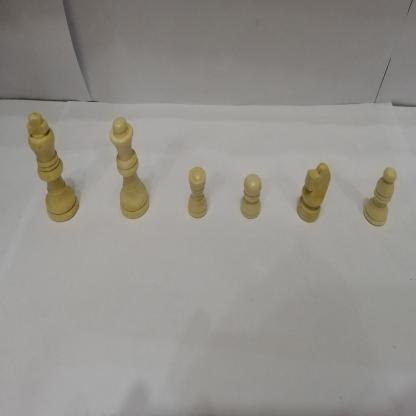

In [ ]:
# run test on person.jpg image that comes with repository
#folder = '/content/Chess-white-3/train/'
# for img in [f for f in os.listdir(dataset.location + '/train') if f.endswith('jpg')]:
#   print(dataset.location + '/train/' + img)
  
image = cv2.imread('/content/Chess-white-3/test/msg1775147927-21282_jpg.rf.21a1d9c544e2d1344d1edcdd489dfece.jpg')
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

## Helper Functions
Here are a few helper functions defined that will be used to easily convert between different image types within our later steps.

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## YOLOv4 on Wecam Images
Running YOLOv4 on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** which runs JavaScript code to utilize your computer's webcam. The code snippet will take a webcam photo, which we will then pass into our YOLOv4 model for object detection.

Below is a function to take the webcam picture using JavaScript and then run YOLOv4 on it.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## YOLOv4 on Webcam Videos
Running YOLOv4 on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our YOLOv4 model and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream. 

YOLOv4 is so fast that it can run the detections in real-time!

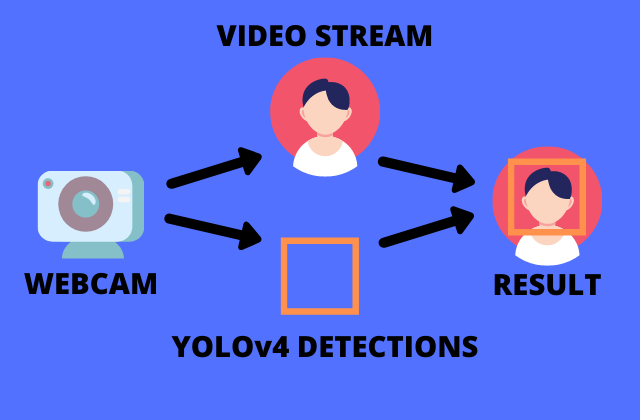

Below is a function to start up the video stream using similar JavaScript as was used for images. The video stream frames are fed as input to YOLOv4.

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Running on Webcam Video

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

## Hope You Enjoyed!
If you enjoyed the tutorial and want to see more videos or tutorials check out my YouTube channel [HERE](https://www.youtube.com/channel/UCrydcKaojc44XnuXrfhlV8Q?sub_confirmation=1)

Have a great day!